# Employee Sentiment Analysis — End-to-End Deliverables

**Inputs**
- Raw emails CSV: `data/test(in).csv` (or your chosen input)
- Cached labels: `data/labeld_sentiments.csv` (auto-created if missing)

**Outputs produced by this notebook**
- Labeled messages: `data/labeld_sentiments.csv`
- EDA figures: `visualizations/*.png`
- Monthly sentiment scores: `data/employee_monthly_sentiment_scores.csv`
- Monthly rankings: `data/employee_monthly_rankings.csv`
- Flight-risk employees: `data/flight_risk_employees.csv`
- Trained linear model: `data/regression_model.joblib`
- Model coefficients: `data/regression_model_coefficients.csv`
- Model diagnostics: `visualizations/model/*.png`

> Spec coverage: sentiment labeling, EDA + visuals, monthly scoring, ranking, flight-risk, linear regression trend model.

**Project:** Springer Capital Employee Sentiment Analysis

**Objective:** Analyze an unlabeled dataset of employee messages to assess sentiment, identify trends, calculate employee scores, rank employees, flag flight risks, and build a predictive regression model.

This notebook follows the project specification, implementing each task sequentially.

---
## 0. Setup and Imports

First, we import all necessary libraries and the custom classes from the `src` directory. We also define key file paths.

In [1]:
import os
import pandas as pd

# Project modules
from src.load_data import LoadData
from src.labeling import SentimentLabeler
from src.plot_data import PlotData
from src.ranking import EmployeeScoring , EmployeeRanking
from src.regression import FeatureEngineer, TrainRegressionModel, PredictScore
from src.model_plotter import ModelPlotter

# I/O
DATA_DIR = "data"
VIZ_DIR = "visualizations"
MODEL_DIR = "data"

RAW_CSV = os.path.join(DATA_DIR, "test(in).csv")  # adjust if your input differs
LABELED_CSV = os.path.join(DATA_DIR, "labeld_sentiments.csv")
MONTHLY_SCORES_CSV = os.path.join(DATA_DIR, "employee_monthly_sentiment_scores.csv")
RANKINGS_CSV = os.path.join(DATA_DIR, "employee_monthly_rankings.csv")
FLIGHT_RISK_CSV = os.path.join(DATA_DIR, "flight_risk_employees.csv")
MODEL_PATH = os.path.join(MODEL_DIR, "regression_model.joblib")
COEFF_PATH = os.path.join(MODEL_DIR, "regression_model_coefficients.csv")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(VIZ_DIR, exist_ok=True)

c:\Users\Baraa\OneDrive\Documents\Projects\baraa-mohaisen-employee-sentiment-analysis\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2) Load and normalize raw data
Parses datetimes, concatenates subject+body, standardizes employee ids and month.


In [2]:
loader = LoadData(RAW_CSV)
raw_df = loader.load_pandas_dataframe(clean=True)

display(raw_df.head(3))
print("Shape:", raw_df.shape)
raw_df.info()


,Subject,body,date,from,text,employee_id,month,text_len,word_count
0,MANUAL WIRE & SAME DAY PAYMENT AUTHORIZATION S...,Attached is the new list of authorized signers...,2010-01-23,bobette.riner@ipgdirect.com,MANUAL WIRE & SAME DAY PAYMENT AUTHORIZATION S...,bobette.riner,2010-01,114,20
1,Central Illinois Light Company,We have received the executed EEI Master Power...,2010-01-25,bobette.riner@ipgdirect.com,Central Illinois Light Company We have receive...,bobette.riner,2010-01,193,32
2,Important FastWeb Scholarship Alert!,Dear Stacy:\n\nA NEW SCHOLARSHIP IS WAITING FO...,2010-02-03,bobette.riner@ipgdirect.com,Important FastWeb Scholarship Alert! Dear Stac...,bobette.riner,2010-02,893,157


Shape: (2191, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Subject      2191 non-null   object        
 1   body         2191 non-null   object        
 2   date         2191 non-null   datetime64[ns]
 3   from         2191 non-null   object        
 4   text         2191 non-null   object        
 5   employee_id  2191 non-null   object        
 6   month        2191 non-null   period[M]     
 7   text_len     2191 non-null   int64         
 8   word_count   2191 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(5), period[M](1)
memory usage: 154.2+ KB


## 3) Sentiment labeling (cached)
Skips recompute if `labeld_sentiments.csv` exists. Produces 3-class labels and polarity.


In [3]:
if os.path.exists(LABELED_CSV):
    df = pd.read_csv(LABELED_CSV, parse_dates=["date"])
else:
    labeler = SentimentLabeler(raw_df.rename(columns={"text": "text"}))
    df = labeler.get_sentiments()
    df.to_csv(LABELED_CSV, index=False)

needed = {"employee_id", "date", "sentiment", "body"}
missing = needed - set(df.columns)
assert not missing, f"Missing columns: {missing}"

display(df.head(3))
print("Labeled rows:", len(df))


,Subject,body,date,from,text,employee_id,sentiment,polarity
0,MANUAL WIRE & SAME DAY PAYMENT AUTHORIZATION S...,Attached is the new list of authorized signers...,2010-01-23,bobette.riner@ipgdirect.com,MANUAL WIRE & SAME DAY PAYMENT AUTHORIZATION S...,bobette.riner,NEUTRAL,0.000430
1,Central Illinois Light Company,We have received the executed EEI Master Power...,2010-01-25,bobette.riner@ipgdirect.com,Central Illinois Light Company We have receive...,bobette.riner,NEUTRAL,0.000358
2,Important FastWeb Scholarship Alert!,Dear Stacy:\n\nA NEW SCHOLARSHIP IS WAITING FO...,2010-02-03,bobette.riner@ipgdirect.com,Important FastWeb Scholarship Alert! Dear Stac...,bobette.riner,NEUTRAL,0.001516


Labeled rows: 2191


## 4) EDA visualizations
Generates and saves figures to `visualizations/`, then displays a curated subset inline.

c:\Users\Baraa\OneDrive\Documents\Projects\baraa-mohaisen-employee-sentiment-analysis\src\plot_data.py:126: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
c:\Users\Baraa\OneDrive\Documents\Projects\baraa-mohaisen-employee-sentiment-analysis\src\plot_data.py:218: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["sentiment_num"]
c:\Users\Baraa\OneDrive\Documents\Projects\baraa-mohaisen-employee-sentiment-analysis\src\plot_data.py:411: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["polarity"]


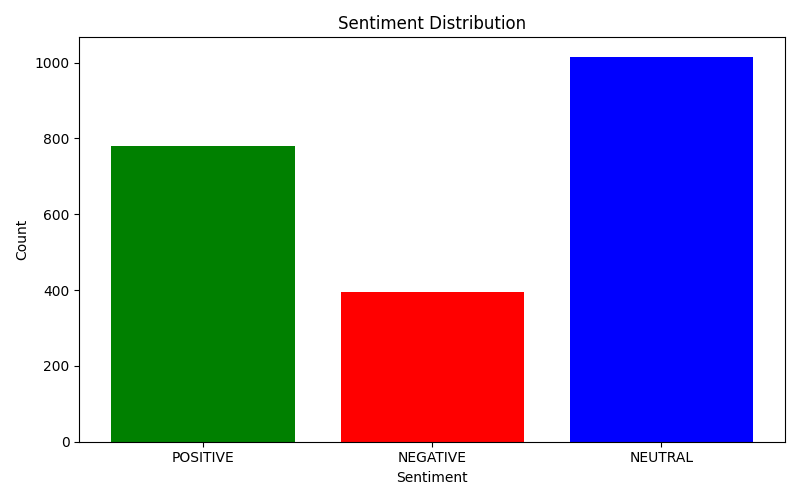

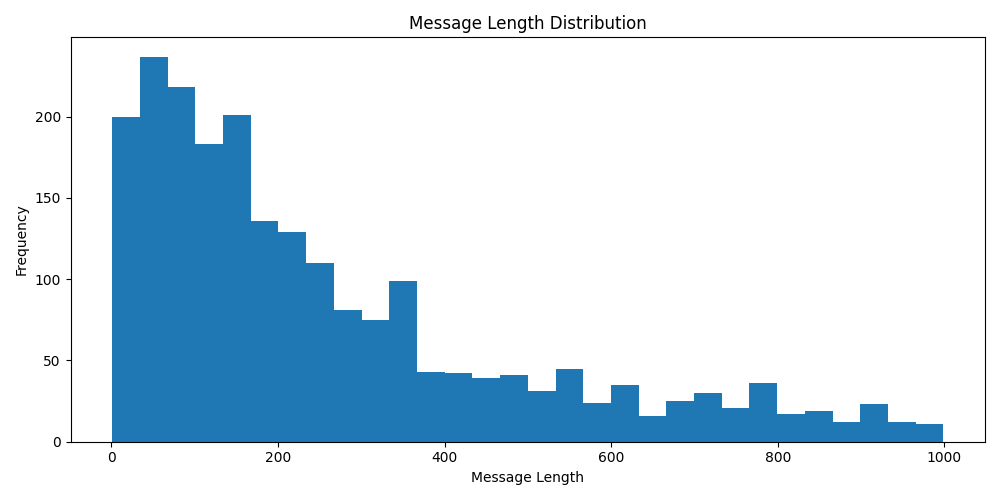

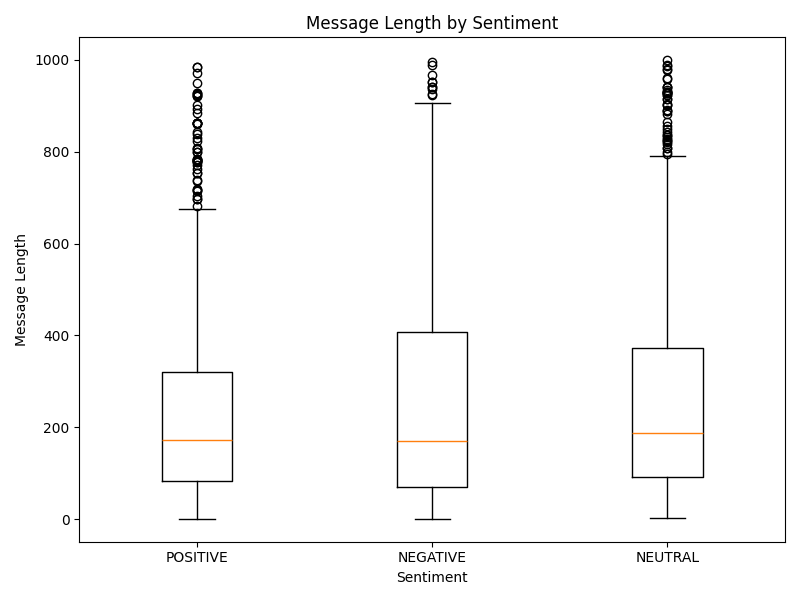

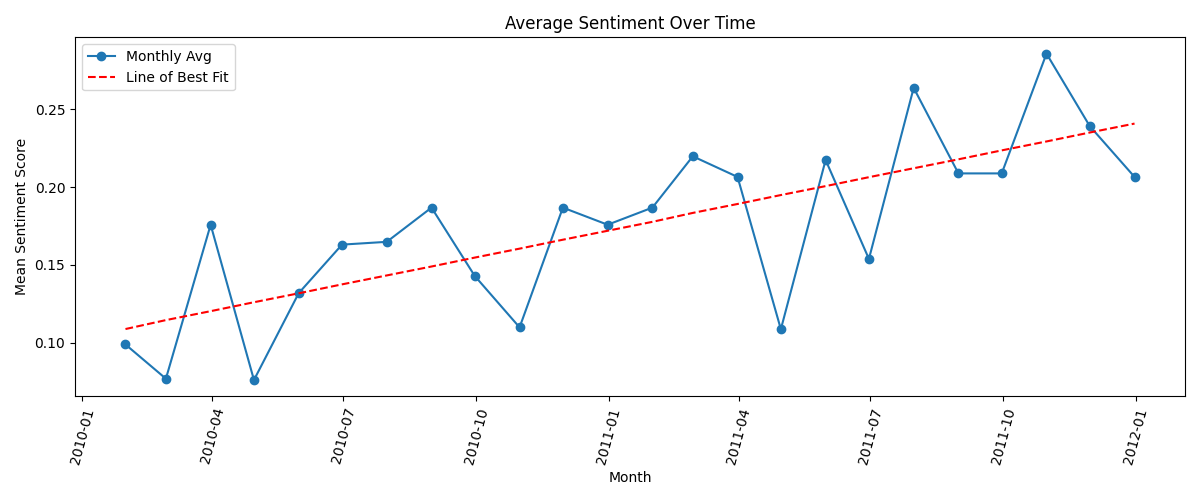

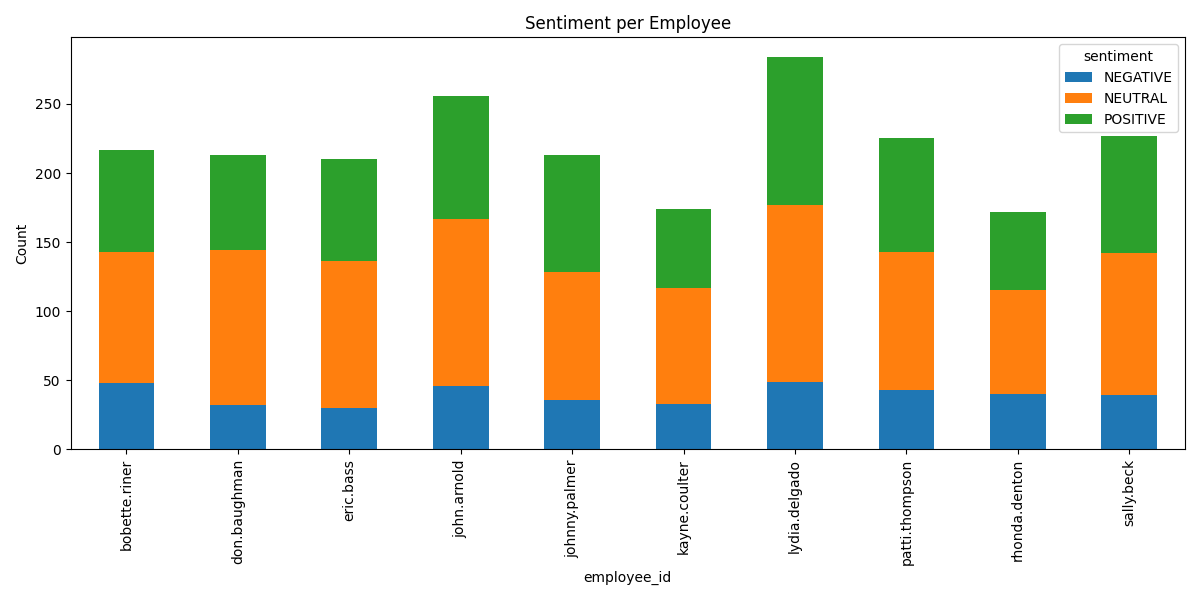

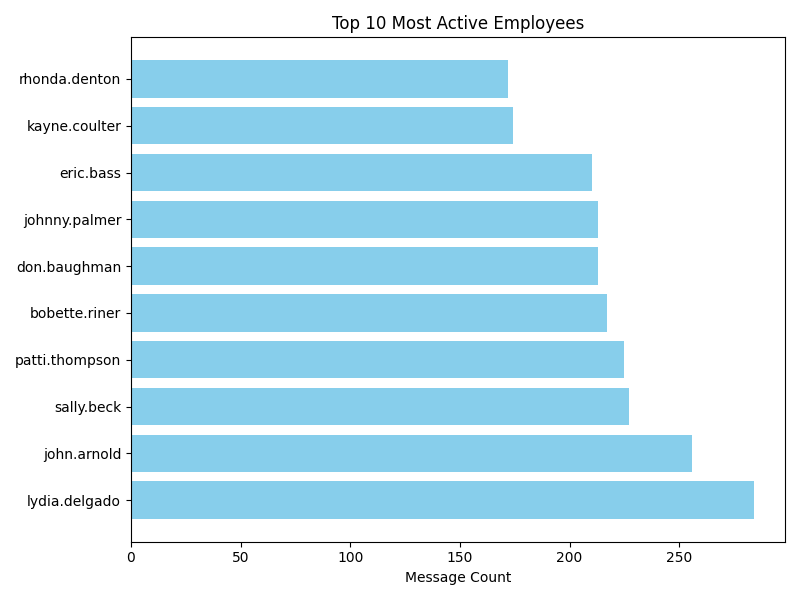

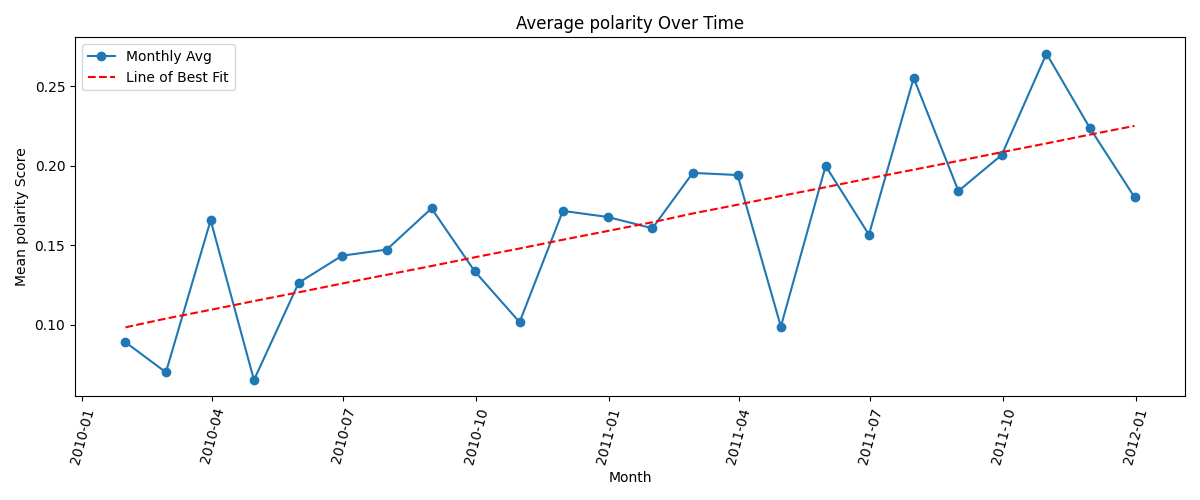

<Figure size 1200x600 with 0 Axes>

In [4]:
eda = PlotData(df)
eda.run_all_plots()  # your helper saves all PNGs under visualizations/

from IPython.display import Image, display

to_show = [
    "visualizations/sentiment_distribution.png",
    "visualizations/message_length_distribution.png",
    "visualizations/message_length_by_sentiment.png",
    "visualizations/avg_sentiment_over_time.png",
    "visualizations/sentiment_per_employee.png",
    "visualizations/top_employees.png",
    "visualizations/avg_polarity_over_time.png",
]
for fn in to_show:
    if os.path.exists(fn):
        display(Image(filename=fn))


## 5) Monthly sentiment scoring
Maps labels → {+1, 0, −1} and aggregates by employee×month.


In [5]:
scorer = EmployeeScoring(df.copy())
monthly_scores = scorer.compute_scores()
monthly_scores.to_csv(MONTHLY_SCORES_CSV, index=False)

display(monthly_scores.head(10))
print("Monthly rows:", len(monthly_scores))


,employee_id,date,sentiment_num
0,bobette.riner,2010-01,0.000000
1,bobette.riner,2010-02,0.833333
2,bobette.riner,2010-03,1.500000
3,bobette.riner,2010-04,-1.000000
4,bobette.riner,2010-05,3.000000
5,bobette.riner,2010-06,-0.500000
6,bobette.riner,2010-07,2.500000
7,bobette.riner,2010-08,-2.000000
8,bobette.riner,2010-09,3.000000
9,bobette.riner,2010-10,2.000000


Monthly rows: 240


## 6) Employee ranking
Top and bottom performers per month based on monthly scores.


In [6]:
ranker = EmployeeRanking(monthly_scores, scores_available=True)
rankings = ranker.get_rankings(drop_type=False)
rankings.to_csv(RANKINGS_CSV, index=False)

display(rankings.head(12))
print("Ranking rows:", len(rankings))


,employee_id,date,sentiment_num,Type
72,kayne.coulter,2010-01,4.500000,Positive
73,johnny.palmer,2010-01,2.000000,Positive
74,eric.bass,2010-01,1.000000,Positive
2,patti.thompson,2010-01,0.166667,Negative
1,bobette.riner,2010-01,0.000000,Negative
0,lydia.delgado,2010-01,-1.000000,Negative
75,don.baughman,2010-02,4.166667,Positive
76,rhonda.denton,2010-02,2.000000,Positive
77,sally.beck,2010-02,1.500000,Positive
5,john.arnold,2010-02,-0.500000,Negative


Ranking rows: 144


## 7) Flight-risk identification
Rule: rolling 30-day count of NEGATIVE messages ≥ 4.
Returns names only and full event summary. Saves CSV.


In [7]:
# names only
risks_names = scorer.flight_risk_analysis(return_names_only=True, min_neg_in_30d=4)
# full details
risks_full = scorer.flight_risk_analysis(return_names_only=False, min_neg_in_30d=4)
risks_full.to_csv(FLIGHT_RISK_CSV, index=False)

display(risks_names.head())
display(risks_full.head(10))
print("At-risk employees:", len(risks_names))


c:\Users\Baraa\OneDrive\Documents\Projects\baraa-mohaisen-employee-sentiment-analysis\src\ranking.py:165: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_within_emp)
c:\Users\Baraa\OneDrive\Documents\Projects\baraa-mohaisen-employee-sentiment-analysis\src\ranking.py:165: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_within_emp)


,employee_id
0,bobette.riner
1,don.baughman
2,eric.bass
3,john.arnold
4,johnny.palmer


,employee_id,first_flight_risk,max_neg_sent_in_30d
0,bobette.riner,2010-03-07,7.0
1,don.baughman,2010-02-25,5.0
2,eric.bass,2011-05-17,6.0
3,john.arnold,2010-02-14,8.0
4,johnny.palmer,2010-02-25,6.0
5,kayne.coulter,2010-01-31,6.0
6,lydia.delgado,2010-04-26,7.0
7,patti.thompson,2010-04-28,8.0
8,rhonda.denton,2010-04-22,6.0
9,sally.beck,2011-01-10,5.0


At-risk employees: 10


### (Optional) Flight-risk visuals
If your plotting module includes them, render saved PNGs.


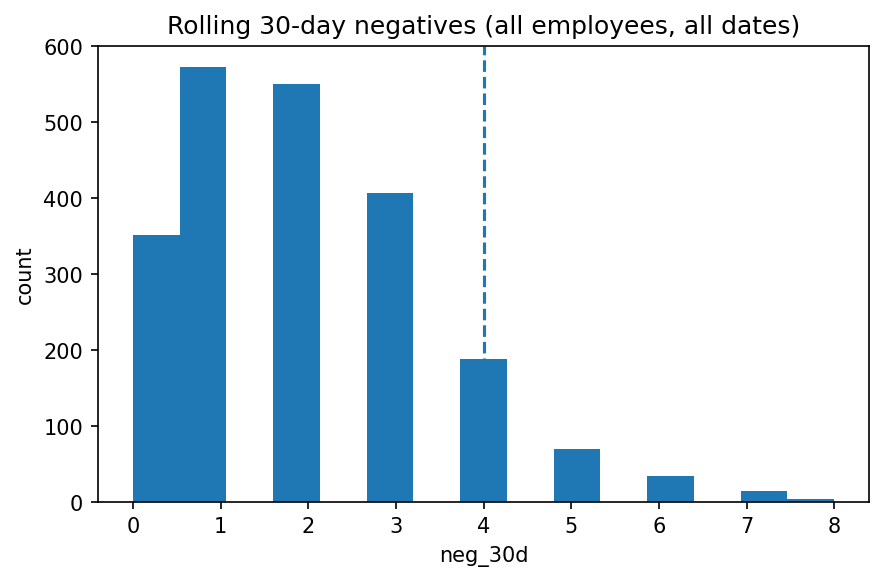

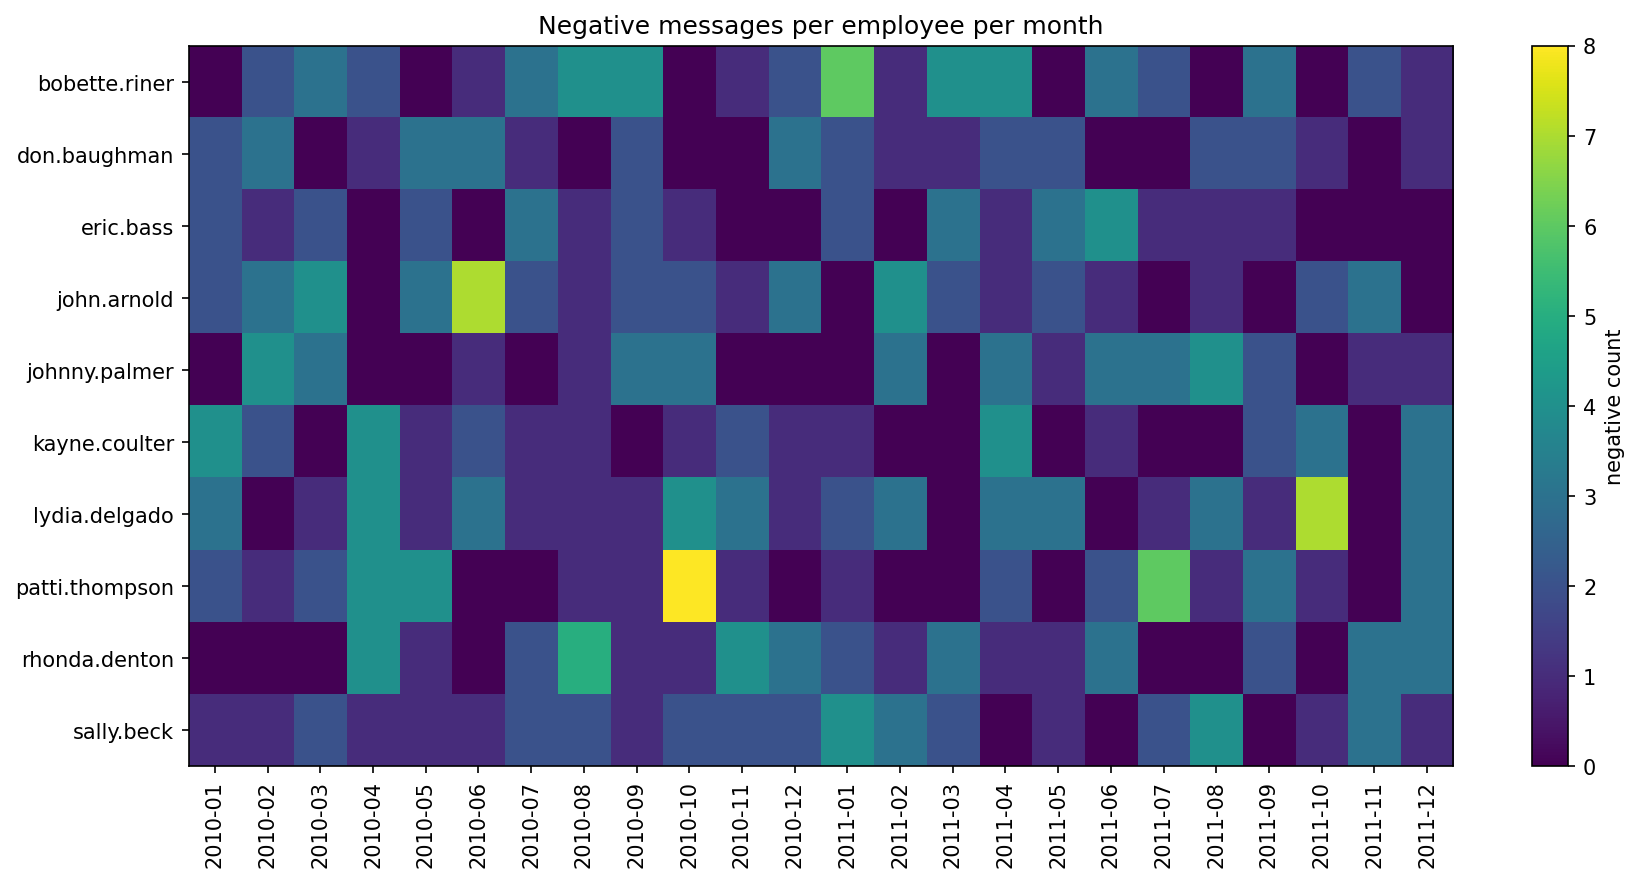

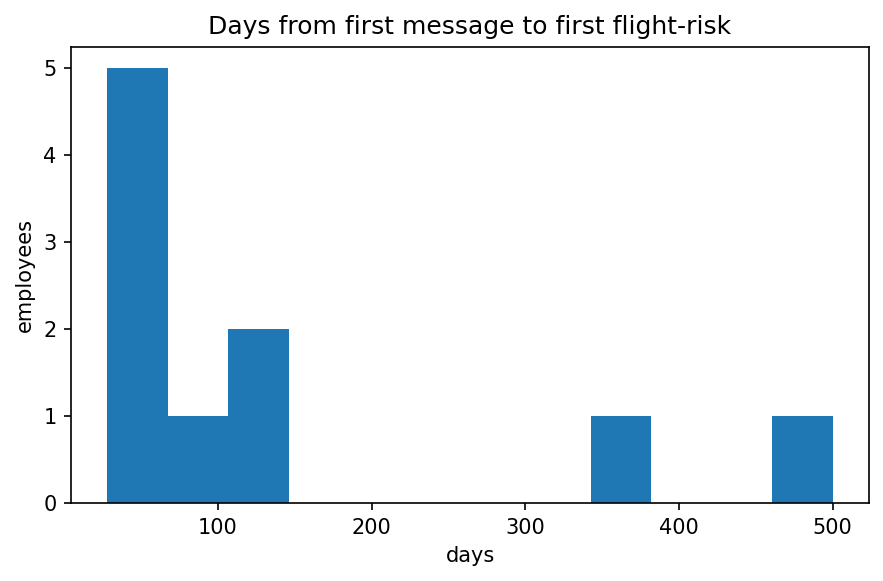

In [ ]:

from src.plot_data import FlightRiskPlots
fr = FlightRiskPlots(df.assign(
    sentiment_num=df.get("sentiment_num", df["sentiment"].map({"POSITIVE":1,"NEUTRAL":0,"NEGATIVE":-1}))
)[["employee_id","date","sentiment_num"]])
fr.run_all()

from IPython.display import Image, display
flight_pngs = [
    "visualizations/flight_risk/dist_neg30d.png",
    "visualizations/flight_risk/heatmap_neg_by_month_employee.png",
    "visualizations/flight_risk/cohort_days_to_first_risk.png",
]
for fn in flight_pngs:
    if os.path.exists(fn):
        display(Image(filename=fn))


## 8) Linear regression for sentiment trends
Trains a linear model (LassoCV over engineered features). Saves model and coefficients.


In [10]:
# Ensure the training helper receives a 'month' column (some modules expect 'month' rather than 'date')
if 'month' not in monthly_scores.columns and 'date' in monthly_scores.columns:
	monthly_scores = monthly_scores.rename(columns={'date': 'month'})

trainer = TrainRegressionModel(sentiment_scores_df=monthly_scores, raw_df=df)
trainer.train(test_size=0.2, random_state=42)
r2 = trainer.evaluate()          # prints metrics and feature importances if implemented
trainer.save_model_artifacts(model_path=MODEL_PATH, coeff_path=COEFF_PATH)

print("R^2 on test:", r2)


Preparing features...
Splitting data...
Training model...


c:\Users\Baraa\OneDrive\Documents\Projects\baraa-mohaisen-employee-sentiment-analysis\.conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.460e-02, tolerance: 5.631e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Baraa\OneDrive\Documents\Projects\baraa-mohaisen-employee-sentiment-analysis\.conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.560e-02, tolerance: 5.854e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Baraa\OneDrive\Documents\Projects\baraa-mohaisen-employee-sentiment-analysis\.conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: 

Training complete.
Evaluating model...
Model R-squared on test set: 0.7926596757287631

--- Top Model Features ---
                                               Feature   Coefficient
30                           text_len avg_raw_polarity  1.146722e+00
158                     avg_raw_polarity sqrt_text_len  3.399192e-01
169          avg_raw_polarity log_sentiment_volatility  1.967110e-01
166     avg_raw_polarity sqrt_avg_subject_caps_density  2.366548e-02
160                  avg_raw_polarity sqrt_avg_msg_len  5.551115e-17
189  is_flight_risk_month previous_month_sentiment_... -2.549103e-02
Saving model to data\regression_model.joblib...
Saving coefficients to data\regression_model_coefficients.csv...
Artifacts saved successfully.
R^2 on test: 0.7926596757287631


c:\Users\Baraa\OneDrive\Documents\Projects\baraa-mohaisen-employee-sentiment-analysis\.conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.205e-01, tolerance: 5.599e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Baraa\OneDrive\Documents\Projects\baraa-mohaisen-employee-sentiment-analysis\.conda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.143e-01, tolerance: 5.599e-02
  model = cd_fast.enet_coordinate_descent(


## 9) Model diagnostics
Residuals, prediction vs actual, top coefficients, and feature correlations.


Initializing ModelPlotter...
Successfully loaded model from data\regression_model.joblib
Re-engineering features for plotting...
Re-creating train/test split...
ModelPlotter ready.
--- Running All Model Plots ---
Plotting residuals...
Plotting prediction vs. actual...
Plotting top coefficients...


c:\Users\Baraa\OneDrive\Documents\Projects\baraa-mohaisen-employee-sentiment-analysis\src\model_plotter.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_features, palette=colors)
c:\Users\Baraa\OneDrive\Documents\Projects\baraa-mohaisen-employee-sentiment-analysis\src\model_plotter.py:173: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  sns.barplot(x='Coefficient', y='Feature', data=top_features, palette=colors)


Plotting correlation heatmap...
--- All Model Plots Saved to 'visualizations/model/' ---


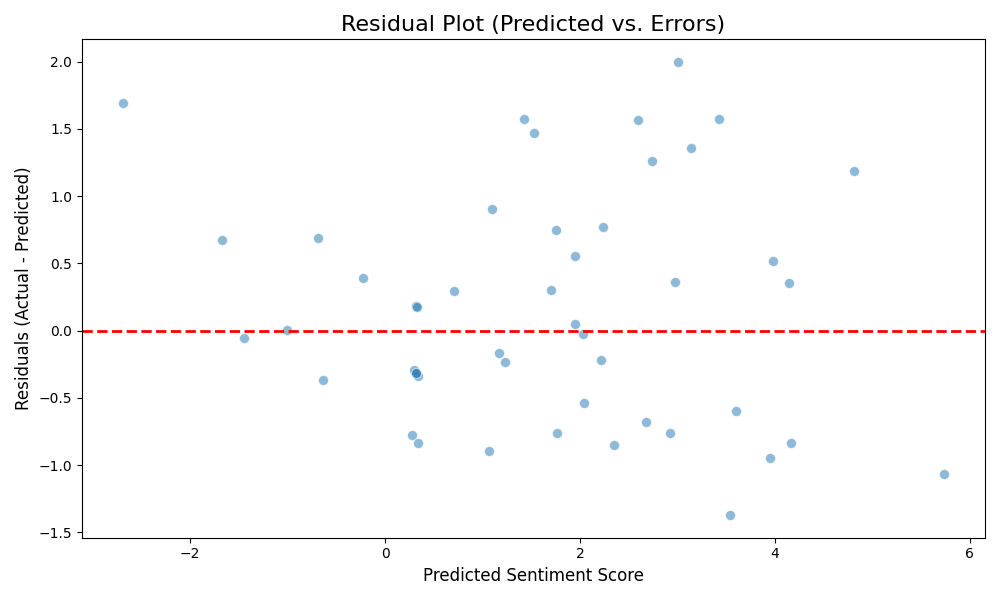

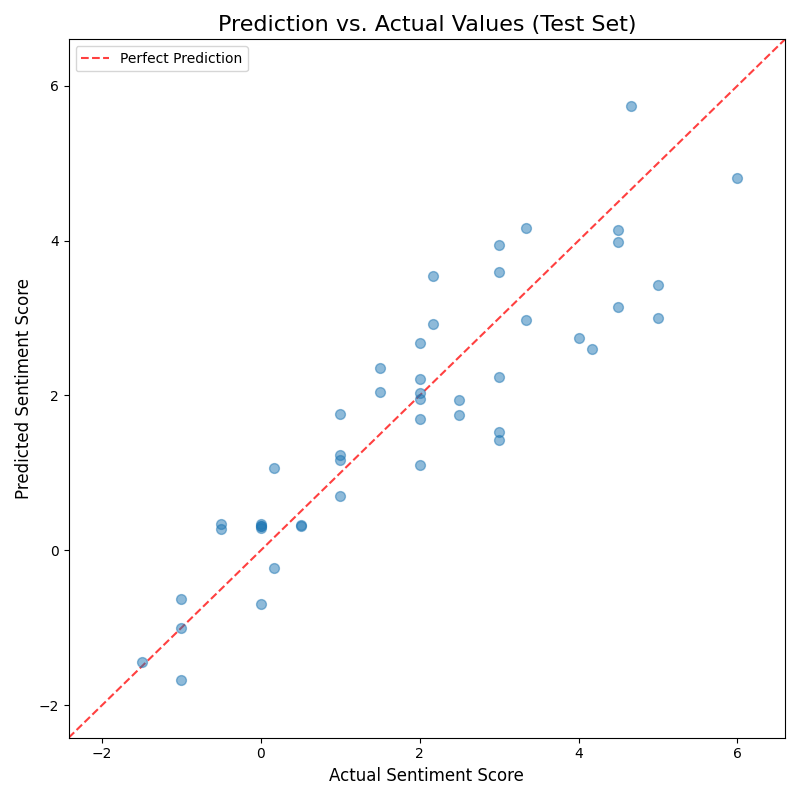

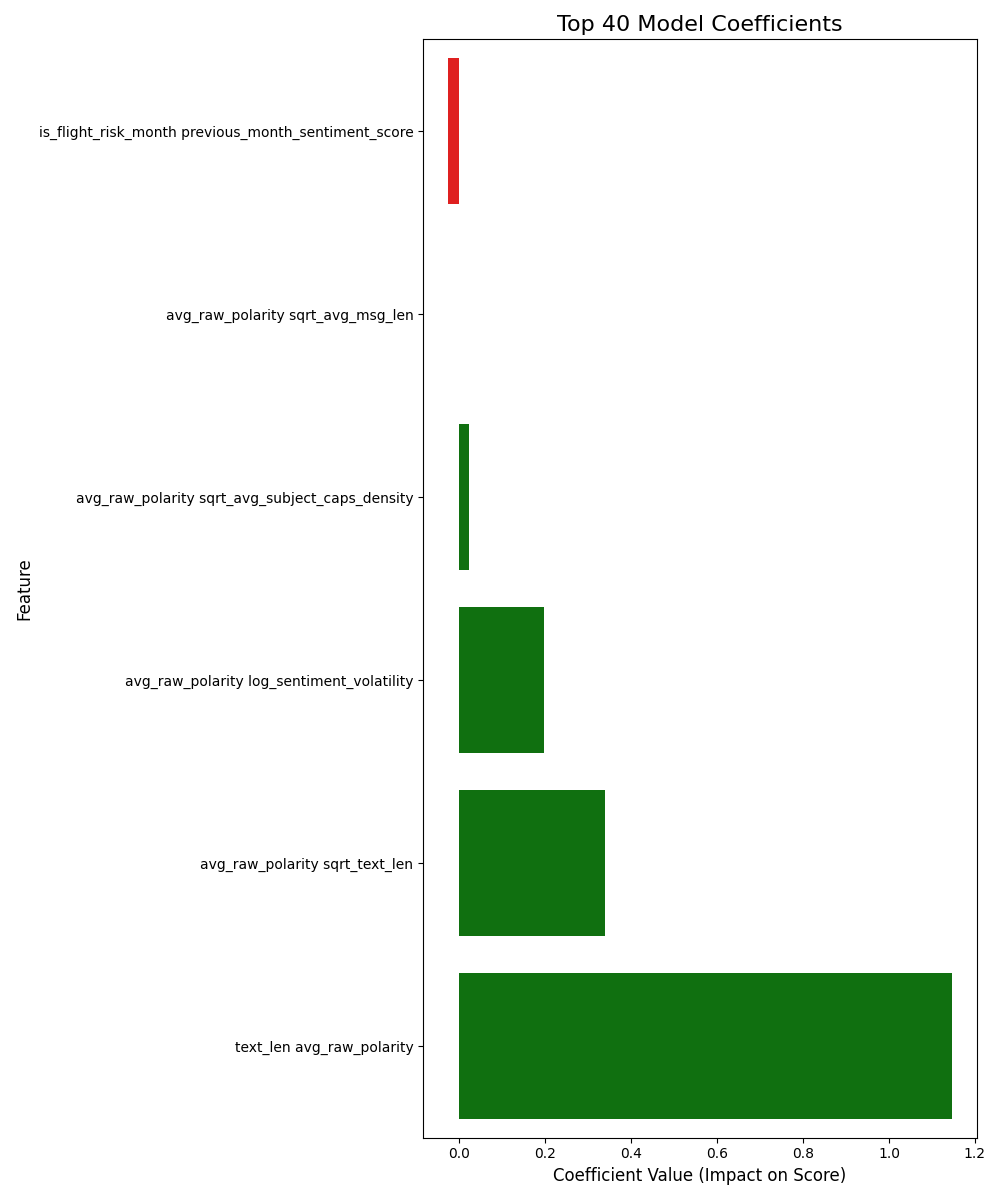

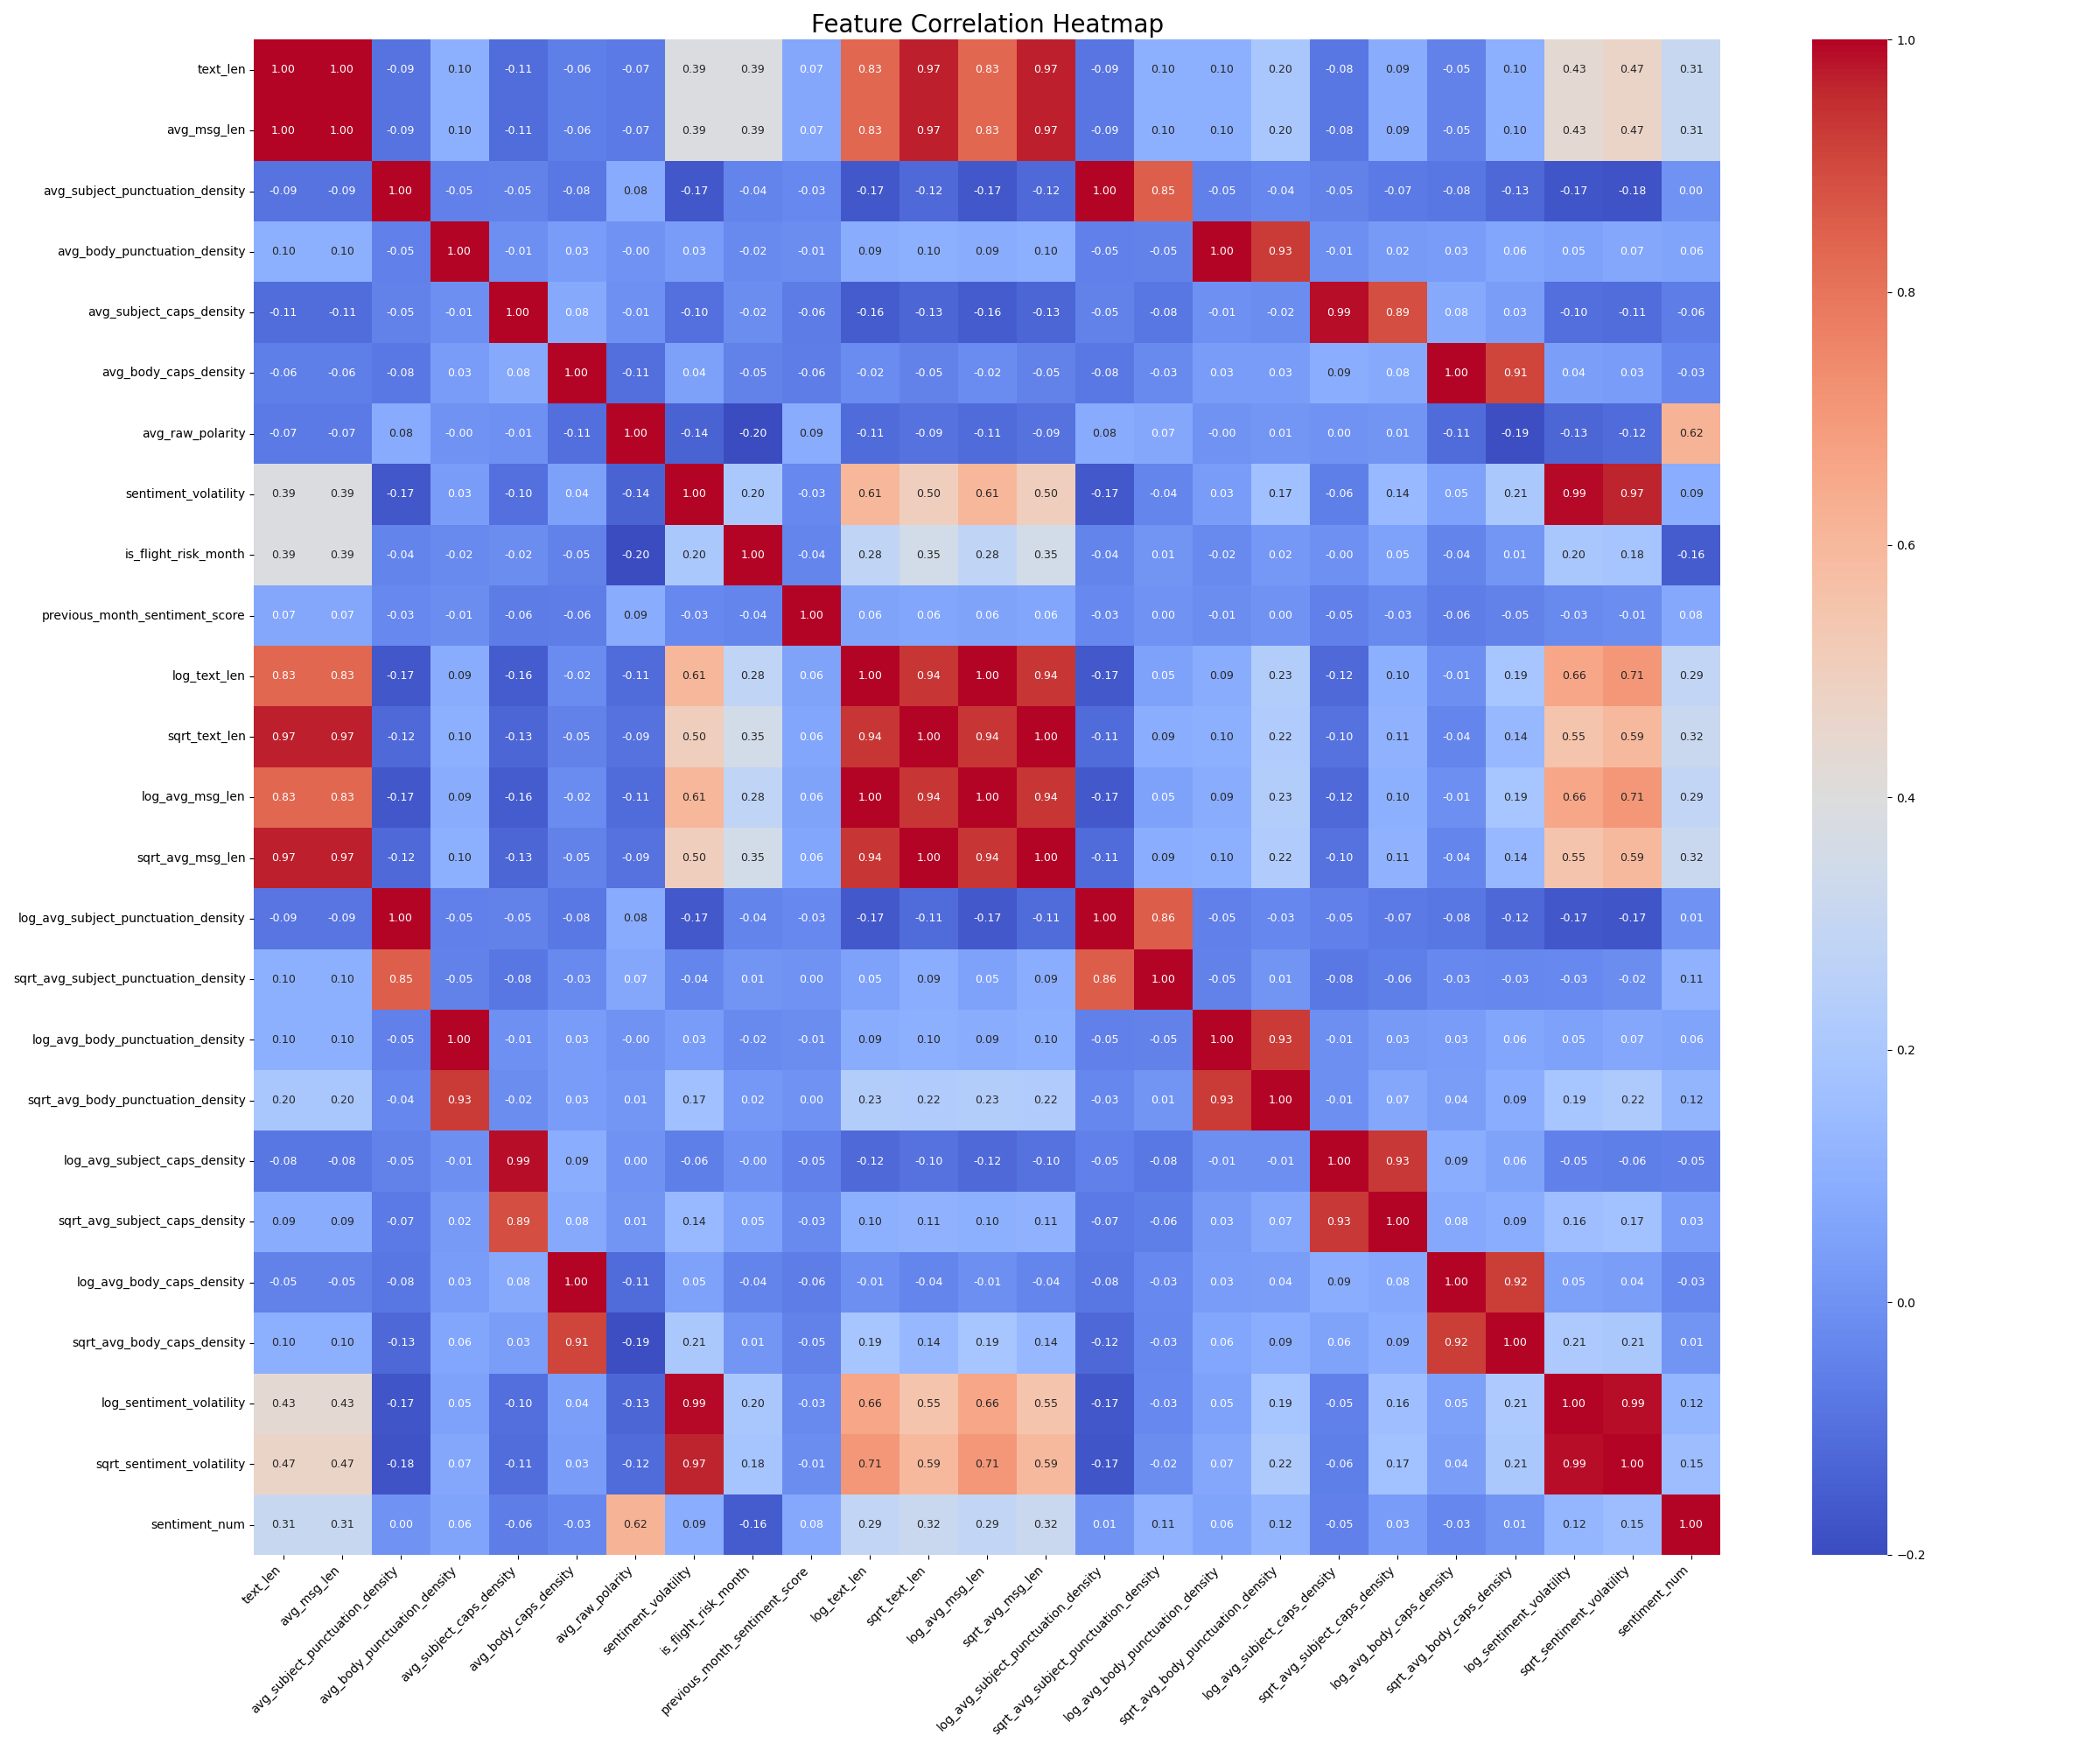

In [11]:
plotter = ModelPlotter(
    raw_df=df,
    sentiment_scores_df=monthly_scores,
    test_size=0.2,
    random_state=42,
    pipeline_path=MODEL_PATH
)
plotter.run_all_plots()

from IPython.display import Image, display
diag_pngs = [
    "visualizations/model/residual_plot.png",
    "visualizations/model/prediction_vs_actual.png",
    "visualizations/model/top_coefficients.png",
    "visualizations/model/feature_correlation_heatmap.png",
]
for fn in diag_pngs:
    if os.path.exists(fn):
        display(Image(filename=fn))


## 10) Example: predict next month
Demonstrates how to call the saved model to generate a trend prediction.


In [43]:
prior_month = "2010-02"
name = "bobette.riner"

# Filter the DataFrame to find the specific row
specific_row = monthly_scores[
    (monthly_scores['employee_id'] == name) & 
    (monthly_scores['month'] == prior_month)
]

# Get the value from the 'sentiment_num' column for that row
sentiment_value = specific_row["sentiment_num"].iloc[0] # .iloc[0] gets the first value from the resulting Series
print(sentiment_value)


0.8333333333333333


In [46]:
# Assume: df (raw labeled), monthly_scores (precomputed), MODEL_PATH set.
# Use the employee from the first row of monthly_scores, predict 2010-03 using prior month 2010-02.

emp_id      = monthly_scores.iloc[0]["employee_id"]
prior_month = "2010-02"
target_month= "2010-03"



# Filter the DataFrame to find the specific row
specific_row = monthly_scores[
    (monthly_scores['employee_id'] == emp_id) & 
    (monthly_scores['month'] == prior_month)
]

# Get the value from the 'sentiment_num' column for that row
sentiment_value = specific_row["sentiment_num"].iloc[0] # .iloc[0] gets the first value from the resulting Series


# rows for that employee; set the month the model should predict for
month_df = df.loc[df["employee_id"].eq(emp_id)].copy()
month_df["month"] = target_month  # let the model’s feature engineer handle this

# predict with just the prior-month identifier
predictor = PredictScore(model_path=MODEL_PATH)
yhat = predictor.predict(month_df, sentiment_value)  # API: (raw_rows, prior_month_str)

# grab actual from monthly_scores for reporting
ms = monthly_scores.copy()
specific_row = monthly_scores[
    (monthly_scores['employee_id'] == emp_id) & 
    (monthly_scores['month'] == target_month)
]
actual = specific_row["sentiment_num"].iloc[0]
print(f"Employee: {emp_id}")
print(f"Prev month used: {prior_month}")
print(f"Target month:    {target_month}")
print(f"Predicted score: {float(yhat if not hasattr(yhat, '__len__') else yhat[0])}")
print(f"Actual score:    {actual}")


Loading model from data\regression_model.joblib...
Model loaded successfully.
Engineering features for new data...
Making prediction...
Employee: bobette.riner
Prev month used: 2010-02
Target month:    2010-03
Predicted score: 0.31477739836287644
Actual score:    1.5


## 11) Deliverables checklist

- ✅ `data/labeld_sentiments.csv`
- ✅ `visualizations/*.png` (EDA)
- ✅ `data/employee_monthly_sentiment_scores.csv`
- ✅ `data/employee_monthly_rankings.csv`
- ✅ `data/flight_risk_employees.csv`
- ✅ `data/regression_model.joblib` and `data/regression_model_coefficients.csv`
- ✅ `visualizations/model/*.png` (diagnostics)

> Re-run policy: labeling is cached; delete `data/labeld_sentiments.csv` only if you need to relabel.


## Appendix — run order and reproducibility
- Run top to bottom on a clean kernel.
- Keep `random_state=42` stable in Sections 8–9.
- Do not overwrite CSVs unless you intend to regenerate downstream artifacts.
